<a href="https://colab.research.google.com/github/Rafi653/Machine-Learning/blob/feature%2Flab_assignment-1.1/ML_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Linear Regression

In [2]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from random import sample

In [3]:
from google.colab import files
file = files.upload()  #upload file into google colab session

housing_df= pd.read_csv('housing.csv', header=None)

concrete_df= pd.read_csv('concreteData.csv', header=None)

yatch_df= pd.read_csv('yachtData.csv', header=None)

Saving concreteData.csv to concreteData.csv
Saving housing.csv to housing.csv
Saving yachtData.csv to yachtData.csv


In [8]:
housing_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
concrete_df.head()

In [ ]:
yatch_df.head()

In [21]:

class LinearRegression:
    def __init__(self,
                 X,
                 y, learningRate,
                 tolerance,
                 maxIteration,
                 gd=False,
                 stochastic=False,
                 reg=False,
                 batch_size=100,
                 alpha=1.0) -> None:
        self.X = X
        self.y = y
        self.tolerance = tolerance
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.gd = gd
        self.stochastic = stochastic
        self.reg = reg
        self.batch_size = batch_size
        self.alpha = alpha

    def splitTrainTest(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                            test_size=0.3,
                                                            random_state=1)
        return (X_train, X_test, y_train, y_test)

    def add_X0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize(self, X):
        mean = np.mean(X, 0)
        std = np.std(X, 0)
        X_norm = (X - mean) / std
        X_norm = self.add_X0(X_norm)
        return X_norm, mean, std

    def normalizetestdata(self, X, meanTrain, stdTrain):
        X_norm =  (X - meanTrain) / stdTrain
        X_norm = self.add_X0(X_norm)
        return X_norm

    def l2_regularization(self, w):
        """Calculate regularization term."""
        return self.alpha * 0.5 * np.linalg.norm(w, 2)

    def grad_reg_term(self, w):
        gradient_penalty = np.asarray(self.alpha) * w
        # Insert 0 for bias term.
        return np.insert(gradient_penalty, 0, 0, axis=0)

    def checkMatrix(self, X):
        X_rank = np.linalg.matrix_rank(X)

        if X_rank == min(X.shape[0], X.shape[1]):
            self.fullRank = True
            print('data is full rank')
        else:
            self.fullRank = False
            print('data is not full rank')

    def checkInvertibility(self, X):
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
        else:
            self.lowrank = False

    def closedFormSolution(self, X, y):
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return w

    def sgd_sample(self, X, y):

        n_obs = X.shape[0]

        xy = np.c_[X.reshape(n_obs, -1), y.reshape(n_obs, 1)]

        # Initializing the random number generator
        # seed = None if random_state is None else int(random_state)
        rng = np.random.default_rng(seed=None)

        rng.shuffle(xy)
        if not 0 < self.batch_size <= n_obs:
            raise ValueError(
                f"'batch_size' must be greater than zero and less than or equal to the number of observations: {n_obs}")
        start = random.randint(0, n_obs - self.batch_size)

        stop = start + self.batch_size
        x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]
        y_batch = y_batch.reshape(-1)

        return x_batch, y_batch


    def sample_batch(self, X, y):
        s_range = sample(range(0,X.shape[0]), self.batch_size)
        return X[s_range,], y[s_range,]

    def gradientDescent(self, X, y):

        self.errors = []

        lastError = float('inf')

        if self.stochastic:
            print("solving using stochastic gradient descent")
        else:
            print("solving using gradient descent")
        gradient_reg = 0
        regularization = 0
        for t in tqdm(range(self.maxIteration)):
            if self.stochastic:
                #X_batch, y_batch = self.sgd_sample(X, y)
                X_batch, y_batch = self.sample_batch(X, y)
            else:
                X_batch, y_batch = X, y

            if self.reg:
                gradient_reg = self.grad_reg_term(self.w[1:])
                regularization = self.l2_regularization(self.w[1:])

            self.w = self.w - self.learningRate * (self.costDerivation(X_batch, y_batch) + gradient_reg)

            # cur= self.sse(X_batch,y_batch) + regularization
            cur = self.rmse(X_batch, y_batch) + regularization

            diff = lastError - cur
            lastError = cur
            self.errors.append(cur)

            if abs(diff) < self.tolerance:
                print("The model stopped and no further improvement")
                break
        self.plot_cost(self.errors)

    def predict(self, X):
        return X.dot(self.w)

    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()

    def rmse(self, X, y):
        n = X.shape[0]
        return np.sqrt(self.sse(X, y) / n)

    def costFunction(self, X, y):
        return self.sse(X, y) / 2

    def costDerivation(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X)

    def plot_cost(self, cost_sequence):
        # Data for plotting
        s = np.array(cost_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel='cost',
               title='cost trend')
        ax.grid()

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, shadow=True)
        plt.show()

    def fit(self):

        self.X_train, self.X_test, self.y_train, self.y_test = self.splitTrainTest()

        # normalize the data
        self.X_train, meanTrain, stdTrain = self.normalize(self.X_train)
        self.X_test = self.normalizetestdata(self.X_test, meanTrain, stdTrain)

        self.checkInvertibility(self.X_train)
        self.checkMatrix(self.X_train)

        if self.fullRank and not self.lowrank and not self.gd:
            print("Solving using Normal equation - closed form solution")
            self.w = self.closedFormSolution(self.X_train, self.y_train)

        else:
            self.w = np.ones(self.X_train.shape[1], dtype=np.float64) * 0
            self.gradientDescent(self.X_train, self.y_train)

            print(self.w)

    def predict_test(self):
        #self.w = np.ones(self.X_test.shape[1], dtype=np.float64) * 0

        y_hat_test = self.predict(self.X_test)
        rmse_test = self.rmse(self.X_test, self.y_test)
        sse_test = self.sse(self.X_test, self.y_test)
        return y_hat_test, rmse_test, sse_test

In [ ]:
"""
Call RMSE and SSE for test data
and plot them 

"""

Running Model on dataset: housing
data is full rank
solving using stochastic gradient descent


  0%|          | 18/50000 [00:00<00:29, 1705.77it/s]
No handles with labels found to put in legend.


The model stopped and no further improvement


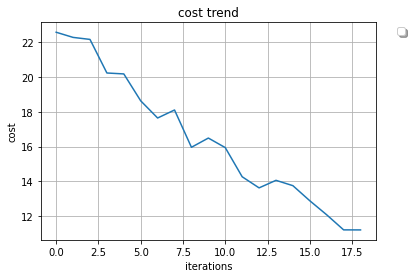

[12.07878753 -0.59880803  0.67297558 -0.61296894  0.74668535 -0.65410743
  1.72531746 -0.48740305 -0.34877256 -0.12617657 -0.36985386 -1.40455697
  0.49022338 -2.00837572]
11.791484421504816 21133.943939113797
Running Model on dataset: concrete
data is full rank
solving using stochastic gradient descent


 51%|█████     | 25515/50000 [00:06<00:06, 3661.94it/s]
No handles with labels found to put in legend.


The model stopped and no further improvement


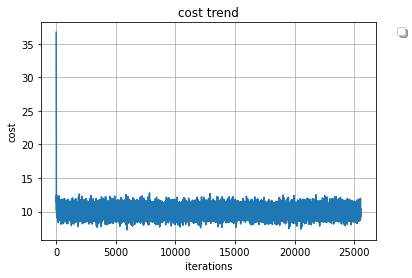

[ 3.56012531e+01  1.13184376e+01  7.60894029e+00  4.01889318e+00
 -3.98781110e+00  2.07652480e+00  3.72280107e-02  3.46190169e-02
  6.99230714e+00]
11.000008550616988 37389.05812711688
Running Model on dataset: yatch
data is full rank
solving using stochastic gradient descent


  7%|▋         | 3618/50000 [00:00<00:09, 4645.89it/s]
No handles with labels found to put in legend.


The model stopped and no further improvement


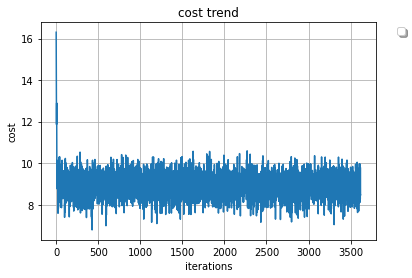

[10.2798049   0.15578834 -0.66813369  1.62036663 -1.4115038  -1.72319896
 12.08561142]
8.675760079019929 6999.999604230578


In [24]:
datasets = [
    {
        'name': 'housing',
        'kwargs': {
            'X': housing_df.values[:, 0:-1],
            'y': housing_df.values[:, -1],
            'learningRate': 0.0004,
            'tolerance': 0.005,
            'maxIteration': 50000,
            'gd': True,
            'stochastic': True,
            'reg': True,
            'batch_size': 100,
            'alpha': 1.0
        }
    },
    {
        'name': 'concrete',
        'kwargs': {
            'X': concrete_df.values[:, 0:-1],
            'y': concrete_df.values[:, -1],
            'learningRate': 0.0007,
            'tolerance': 0.0001,
            'maxIteration': 50000,
            'gd': True,
            'stochastic': True,
            'reg': True,
            'batch_size': 100,
            'alpha': 1.0
        }
    },
    {
        'name': 'yatch',
        'kwargs': {
            'X': yatch_df.values[:, 0:-1],
            'y': yatch_df.values[:, -1],
            'learningRate': 0.001,
            'tolerance': 0.001,
            'maxIteration': 50000,
            'gd': True,
            'stochastic': True,
            'reg': True,
            'batch_size': 100,
            'alpha': 1.0
        }
    }
]

for d in datasets:
    print(f"Running Model on dataset: {d['name']}")
    model = LinearRegression(**d['kwargs'])
    model.fit()
    # print(model.X_train.shape)
    # print(model.X_test.shape)
    result, rmse_test, sse_test = model.predict_test()
    print(rmse_test, sse_test)
